In [1]:
import sys
import os
import json
import numpy as np
import pandas as pd
from IPython.display import IFrame

# Change dir to root dir
parent_dir = os.path.abspath(os.path.join(os.getcwd(), ".."))
os.chdir(parent_dir)
print("Current Working Directory:", os.getcwd())

from src.data import generate_df, convert_to_gdf, generate_gdf, preprocess_df
from src.plot import plot_data, plot_kde, plot_correlation_matrix, plot_map
from src.model import light_gbm, predict_light_gbm_model, cluster_kmeans_nam_data
from src.data import generate_df, convert_to_gdf, generate_gdf, preprocess_df, preprocess_gdf, filter_nam_outside_vri, get_nam_outside_vri_nearest_station
from src.scripts.generateNamCSV import generate_nam_csv
from src.scripts.generateElevationCSV import generate_elevation_csv
from src.analysis import custom_groupby, find_outliers_iqr

Current Working Directory: /home/ssahar/private/DSC180B


In [2]:
with open('config/data_params.json') as fh:
        data_params = json.load(fh)    

raw_data_path = [os.path.join('./data/raw', file_path) for file_path in data_params["raw_data"]]
modified_data_path = [os.path.join('./data/modified', file_path) for file_path in data_params["modified_data"]]
output_model_path = [os.path.join('./data/modified', file_path) for file_path in data_params["model_prediction"]]

In [3]:
# Reading raw data
gis_weather_station, src_vri_snapshot, nam, windspeed_snapshot = generate_df(raw_data_path) 
gis_weather_station, windspeed_snapshot = preprocess_df(gis_weather_station, windspeed_snapshot)

# Reading filtered data with elevation from API
gis_weather_station_with_elevation, nam_with_elevation = generate_df(modified_data_path)
gis_weather_station_with_elevation_gpd, src_vri_snapshot_gpd, nam_with_elevation_gpd = generate_gdf(
    gis_weather_station_with_elevation, src_vri_snapshot, nam_with_elevation)

# Readiing data from LightGBM model
nam_within_vri_prediction, nam_outside_vri_prediction = generate_df(output_model_path)
nam_within_vri_prediction_gpd, nam_outside_vri_prediction_gpd = convert_to_gdf(nam_within_vri_prediction, True), convert_to_gdf(nam_outside_vri_prediction)

Weather Station CRS:    EPSG:4326
VRI Polygon CRS:        EPSG:4326
NAM CRS:                EPSG:4326


/home/ssahar/private/DSC180B/src/data.py:9: DtypeWarning: Columns (46) have mixed types. Specify dtype option on import or set low_memory=False.
  return [pd.read_csv(file) for file in input_list]


## NAM Points Within VRI Polygon

In [4]:
# Wind speed error difference to evaluate the LightGBM model
nam_within_vri_prediction_gpd['wind_speed_error_diff'] = (nam_within_vri_prediction_gpd['abs_wind_speed_error'] - 
                                                     nam_within_vri_prediction_gpd['abs_wind_speed_error_pred']).abs()

agg_dict_within = {
    'abs_wind_speed_error': 'mean',
    'wind_speed_error_diff': 'mean',
    'nam_distance_from_station_km': 'mean'
}

# Group the data based on each NAM points
nam_mae_within = custom_groupby(nam_within_vri_prediction_gpd, ['geometry'], agg_dict_within)
nam_mae_within['distance_weight_error'] = nam_mae_within['abs_wind_speed_error'] * nam_mae_within['nam_distance_from_station_km']
nam_mae_within.head()

,geometry,abs_wind_speed_error,wind_speed_error_diff,nam_distance_from_station_km,distance_weight_error
0,POINT (-117.10672 32.54224),8.637497,2.353360,0.944333,8.156673
1,POINT (-117.09059 32.54212),8.643125,2.720831,0.571670,4.941018
2,POINT (-117.07446 32.54202),8.646338,2.754249,2.086517,18.040730
3,POINT (-117.05774 32.5963),6.400400,1.377936,0.588202,3.764726
4,POINT (-117.05789 32.5827),6.337770,1.186923,2.096557,13.287498


In [5]:
# Outlier wind speed error on upgrouped nam data
abs_wind_speed_error_outlier = find_outliers_iqr(nam_within_vri_prediction_gpd, 'abs_wind_speed_error')
print(f"Wind Speed Error Outlier Threshold: {abs_wind_speed_error_outlier}")

# Outlier wind speed error grouped based on each nam points
MAE_outlier = find_outliers_iqr(nam_mae_within, 'abs_wind_speed_error')
print(f"MAE Outlier Threshold: {MAE_outlier}")

# Average wind speed error of ungrouped data between nam points and weather stations points
average_wind_speed_error = nam_within_vri_prediction_gpd['abs_wind_speed_error'].mean()
print(f"Average Wind Speed Error: {average_wind_speed_error}")

# Average Mean Absolute Error
average_MAE = nam_mae_within['abs_wind_speed_error'].mean()
print(f"Average MAE: {average_MAE}")

# Average error between actual error and predicted error
average_wind_speed_error_diff = nam_within_vri_prediction_gpd['wind_speed_error_diff'].mean()
print(f"Average Difference of Wind Speed Error: {average_wind_speed_error_diff}")

Wind Speed Error Outlier Threshold: [-6.7941805, 25.3020115]
MAE Outlier Threshold: [0.8351507310344823, 18.32086459310345]
Average Wind Speed Error: 9.936761864616754
Average MAE: 10.03552867650483
Average Difference of Wind Speed Error: 2.268688147948459


The upper bound wind speed error outlier threshold for ungrouped NAM data is 25.302 while the MAE upper bound outlier threshold value that is grouped based on each NAM points is 18.320. We are going to be using the latter threshold value as it removes the temporal dependencies that may exist in the ungrouped dataset.

For each data points in the ungrouped dataset, the average wind speed error between weather station and NAM is 9.9367.

Using the LightGBM model to predict the error, the average error difference between actual error and predicted error is 2.2686.

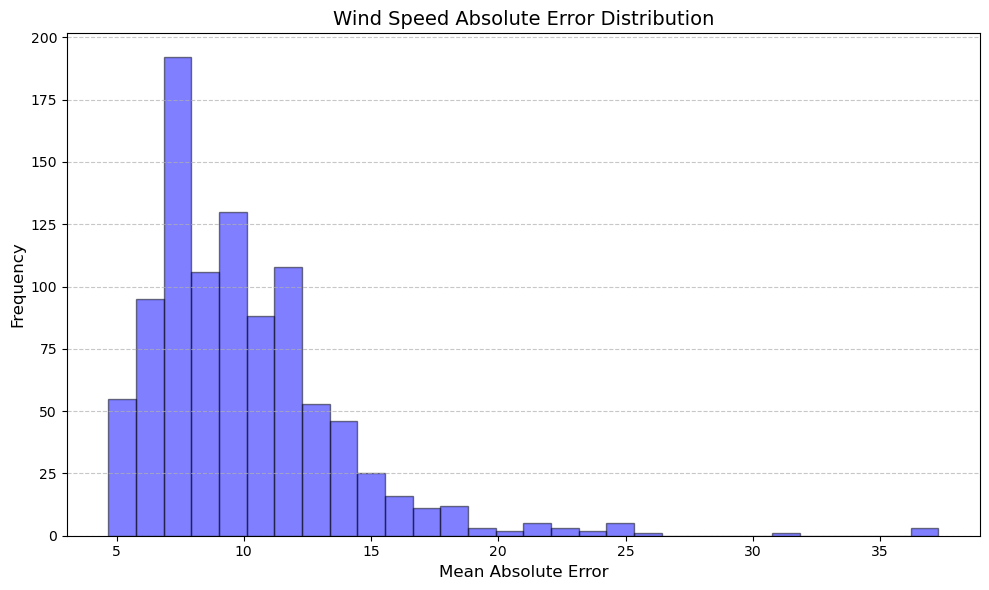

In [6]:
plot_data(nam_mae_within, x='abs_wind_speed_error', title='Wind Speed Absolute Error Distribution',
          xlabel='Mean Absolute Error')

This histogram visualizes the distribution of the Mean Absolute Error of each NAM points. This indicates that the Mean Absolute Error is right-skewed centered at 10 which suggests that there are some points with significantly higher errors, pulling the tail of the distribution to the right.

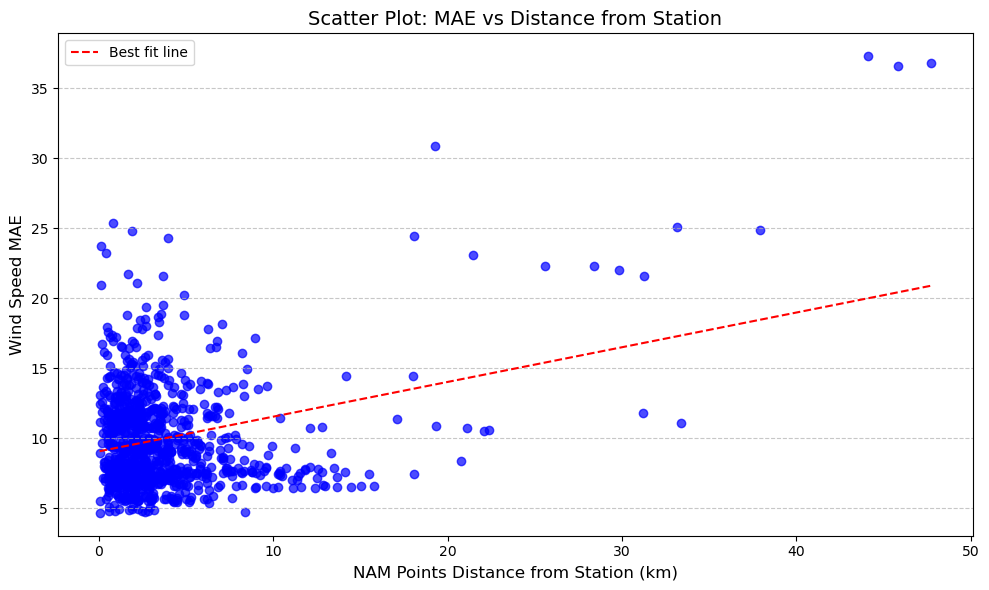

In [7]:
plot_data(nam_mae_within, x='nam_distance_from_station_km', y='abs_wind_speed_error', plot_type='scatter', 
          title='Scatter Plot: MAE vs Distance from Station', xlabel='NAM Points Distance from Station (km)', ylabel='Wind Speed MAE')

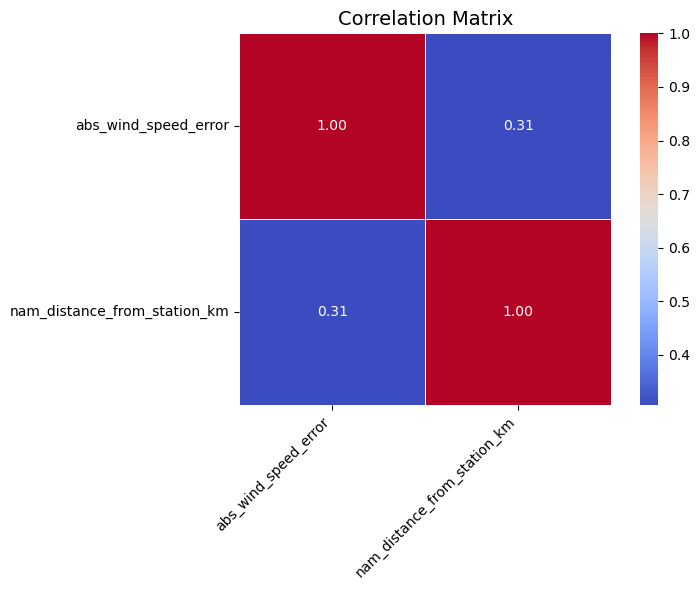

In [8]:
plot_correlation_matrix(nam_mae_within[['abs_wind_speed_error', 'nam_distance_from_station_km']], method="pearson", 
                        title="Correlation Matrix", cmap="coolwarm", annot=True)

Another relationship we would like to uncover is the correlation between the distance of NAM points from its respective weather station and the MAE of the NAM points. Based on our plot, there is a slight correlation between these 2 variables with a coefficient of 0.31. This suggests that as the distance between a NAM point and its respective weather station increases, the MAE of the NAM predictions tends to increase as well, though the relationship is not particularly strong. This could be due to the fact that weather stations provide localized ground-truth measurements, while NAM predictions are based on gridded numerical simulations, meaning that farther NAM points may rely on interpolations over larger areas, leading to higher errors. Additionally, terrain variations and microclimate effects may contribute to this trend, as areas with significant elevation changes or unique atmospheric conditions could cause NAM predictions to diverge more from actual observations. The moderate correlation also suggests that while distance plays a role, other factors such as elevation differences, land cover, and atmospheric variability likely influence NAM accuracy as well.

In [9]:
plot_map(gis_weather_station_with_elevation_gpd, src_vri_snapshot_gpd, nam_mae_within, 'abs_wind_speed_error', "nam_within_vri.html")
IFrame("../plots/nam_within_vri.html", width=700, height=500)

This map visualizes the Mean Absolute Error of NAM points within the VRI polygons. The color gradient ranges from yellow (indicating low error) to red (indicating high error).

In [10]:
# Filtering NAM Points with Outlier MAE
plot_map(gis_weather_station_with_elevation_gpd, src_vri_snapshot_gpd, nam_mae_within[nam_mae_within['abs_wind_speed_error'] > MAE_outlier[1]], 
         'abs_wind_speed_error', "nam_within_vri_outlier.html")
IFrame("../plots/nam_within_vri_outlier.html", width=700, height=500)

This map visualizes the NAM points with outlier Mean Absolute Errors (MAE). We observe that NAM points located within thin and elongated VRI polygons tend to exhibit higher errors, particularly at the upper end of the outlier spectrum. This is likely because these VRI polygons contain only a single weather station, and as the distance between the NAM point and the station increases, the accuracy of the NAM predictions decreases. The greater the distance, the less representative the weather station’s measurements become, leading to higher discrepancies between observed and predicted values.

This pattern suggests that spatial coverage limitations in elongated VRI polygons may be a key factor contributing to NAM prediction errors. Since these polygons are stretched over larger distances with only one station, they may fail to capture localized weather variations effectively. As a result, NAM points located farther from the station experience greater prediction uncertainty. Addressing this issue could involve optimizing the placement of weather stations within such polygons or assigning these points to a different weather station with a closer proximity.

There are points within more compact VRI polygons such as the ones within the Dye Mountain VRI with an error of about 20. In comparison, points within an elongated polygon such as the TL50003 Polygon have an error ranging from 25-35.

In [11]:
plot_map(gis_weather_station_with_elevation_gpd, src_vri_snapshot_gpd, nam_mae_within.sort_values(by='abs_wind_speed_error', ascending=False).head(20), 
         'abs_wind_speed_error', "nam_within_vri_top_20.html")
IFrame("../plots/nam_within_vri_top_20.html", width=700, height=500)

The observation above holds true when filtering for the top 20 points with the highest MAE.

In [12]:
plot_map(gis_weather_station_with_elevation_gpd, src_vri_snapshot_gpd, nam_mae_within.sort_values(by='distance_weight_error', ascending=False).head(20), 
         'distance_weight_error', "nam_within_vri_distance_weighted.html")
IFrame("../plots/nam_within_vri_distance_weighted.html", width=700, height=500)

In [13]:
plot_map(gis_weather_station_with_elevation_gpd, src_vri_snapshot_gpd, 
         nam_mae_within.sort_values(by='nam_distance_from_station_km', ascending=False).head(20), 
         'nam_distance_from_station_km', "nam_within_vri_distance_weighted.html")
IFrame("../plots/nam_within_vri_distance_weighted.html", width=700, height=500)

These two maps display the top 20 points with the highest distance-weighted MAE error and the greatest distance from their respective weather stations. There is noticeable overlap between the two sets of points, highlighting a clear trend: points located within elongated VRI polygons tend to not only be farther from their designated weather stations but also exhibit higher MAE errors.

This trend suggests that as the distance from the station increases, the accuracy of the NAM predictions diminishes, leading to larger errors. The elongated shape of these polygons may exacerbate this issue by spreading the points over a larger area, where localized weather variations are not captured effectively by the station data. This correlation between distance and error underscores the importance of improving station coverage in areas with such elongated polygons.

### Polygon MAE Analysis

In [14]:
agg_dict_within_polygon = {
    'abs_wind_speed_error': 'mean',
    'shape_area': 'mean'
}

# Group data based on VRI Polygon
vri_mae_within = custom_groupby(nam_within_vri_prediction_gpd, ['name'], agg_dict_within_polygon)

# Get the top 20 polygon with the highest error
top_error_outside_vri = vri_mae_within.sort_values(by='abs_wind_speed_error', ascending=False).head(20)
top_error_outside_vri.head()

,name,abs_wind_speed_error,shape_area
150,TL50003_VRI,35.852259,2.815642e+07
93,Otay Mountain_VRI,24.310023,5.420389e+06
42,East Willows Rd_VRI,23.736281,1.635564e+06
54,Hellhole Canyon_VRI,23.202737,1.948968e+06
162,TL686_VRI,22.624386,3.212735e+07


In [15]:
# Get the VRI Polygons with the top 20 error
nam_within_vri_prediction_gpd_top_error = nam_within_vri_prediction_gpd[nam_within_vri_prediction_gpd['name'].isin(
    top_error_outside_vri['name'])]
src_vri_snapshot_gpd_top_error = src_vri_snapshot_gpd[src_vri_snapshot_gpd['name'].isin(top_error_outside_vri['name'])]

# Get the NAM points within the top 20 error VRi Polygon
nam_mae_within_top_error = custom_groupby(nam_within_vri_prediction_gpd_top_error, ['geometry'], agg_dict_within)
nam_mae_within_top_error.head()

,geometry,abs_wind_speed_error,wind_speed_error_diff,nam_distance_from_station_km
0,POINT (-116.8631 32.6627),24.855839,2.849180,37.893164
1,POINT (-116.84729 32.63534),24.310023,4.642887,3.976683
2,POINT (-116.81482 32.64864),25.086965,2.509608,33.150024
3,POINT (-116.65346 32.6334),15.808543,3.547251,2.626662
4,POINT (-116.6373 32.63321),15.701786,3.557425,1.730121


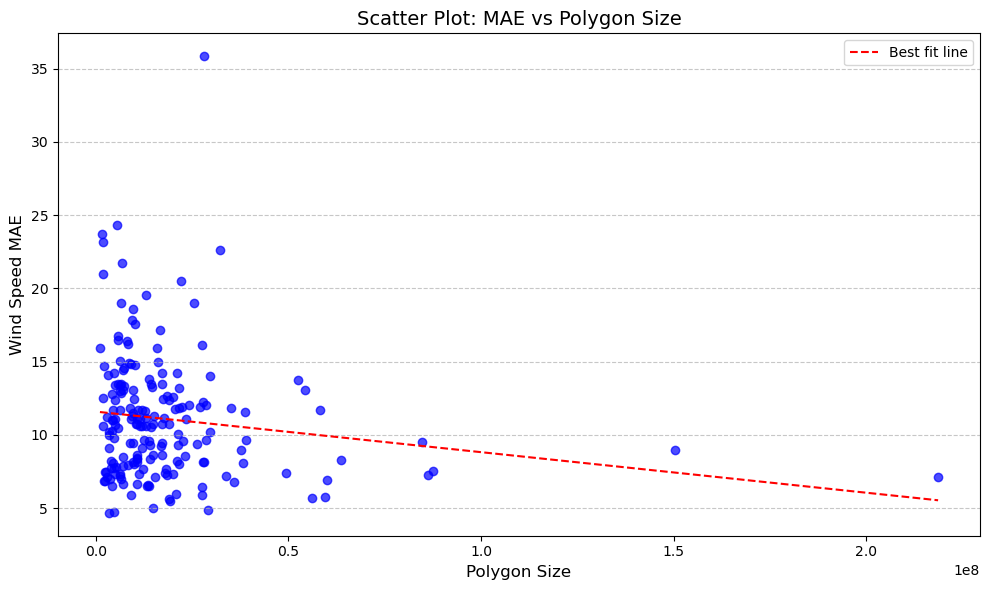

In [16]:
plot_data(vri_mae_within, x='shape_area', y='abs_wind_speed_error', plot_type='scatter', 
          title='Scatter Plot: MAE vs Polygon Size', xlabel='Polygon Size', ylabel='Wind Speed MAE')

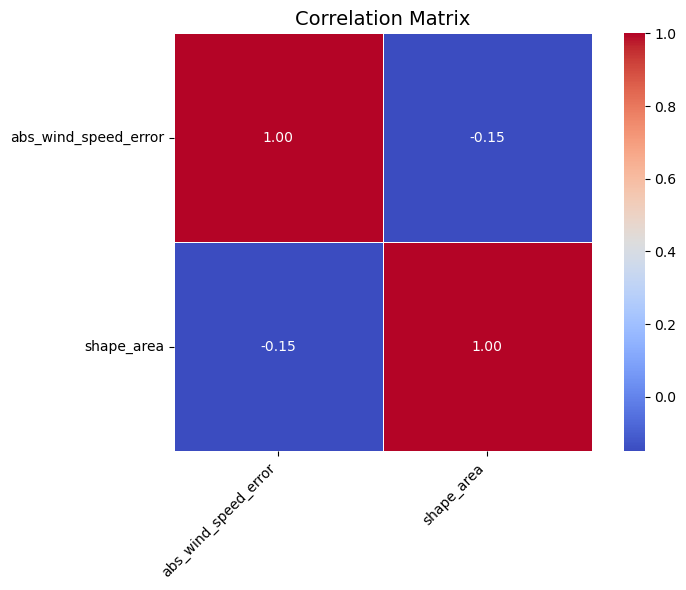

In [17]:
plot_correlation_matrix(vri_mae_within[['abs_wind_speed_error', 'shape_area']], method="pearson", 
                        title="Correlation Matrix", cmap="coolwarm", annot=True)

We also wanted to explore whether the size of the VRI polygon has any impact on the Mean Absolute Error (MAE). Initially, we hypothesized that larger polygons would result in higher MAE values, as they may cover more diverse terrain and atmospheric conditions, potentially leading to less accurate NAM predictions. However, our plot, which shows a correlation matrix of -0.15, reveals a weak negative correlation between polygon size and MAE.

This suggests that, contrary to our initial assumption, larger polygons do not necessarily correspond to higher errors. In fact, the weak negative correlation indicates that as the size of the polygon increases, the MAE tends to slightly decrease. This might be skewed by the thin and elongated polygons which have a relatively smaller area but larger error.

In [18]:
plot_map(gis_weather_station_with_elevation_gpd, src_vri_snapshot_gpd_top_error, nam_mae_within_top_error, 
         'abs_wind_speed_error', "nam_within_vri_top_polygon_error.html")
IFrame("../plots/nam_within_vri_top_polygon_error.html", width=700, height=500)

This map visualizes the top 20 VRI polygons with the highest Mean Absolute Error (MAE). From the visualization, we can observe that both thin, elongated polygons and smaller polygons tend to exhibit higher errors. 

## NAM Points Outside VRI Polygon

In [19]:
agg_dict_outside = {
    'abs_wind_speed_error_pred': 'mean',
}

nam_mae_outside = custom_groupby(nam_outside_vri_prediction_gpd, ['geometry'], agg_dict_outside)
nam_mae_outside.head()

,geometry,abs_wind_speed_error_pred
0,POINT (-117.15411 32.6514),7.108477
1,POINT (-117.15398 32.66501),7.303985
2,POINT (-117.13782 32.6649),7.275315
3,POINT (-117.12166 32.66479),7.039018
4,POINT (-117.1218 32.65119),6.799315


In [20]:
abs_wind_speed_pred_error_outlier = find_outliers_iqr(nam_outside_vri_prediction_gpd, 'abs_wind_speed_error_pred')
print(f"Wind Speed Error Outlier Threshold: {abs_wind_speed_pred_error_outlier}")

nam_mae_outside_outlier = find_outliers_iqr(nam_mae_outside, 'abs_wind_speed_error_pred')
print(f"MAE Outside VRI Polygon Outlier: {nam_mae_outside_outlier}")

Wind Speed Error Outlier Threshold: [-4.047171168138618, 25.37229686538656]
MAE Outside VRI Polygon Outlier: [1.3700446185829955, 20.096426273820505]


The outlier for the raw temporal data for NAM points outside the VRI polygon is 25.372, while the outlier for the grouped NAM data is 20.0964. Given that we are focusing on grouped NAM data, we will use the latter value of 20.0964 as the outlier threshold.

In [21]:
plot_map(gis_weather_station_with_elevation_gpd, src_vri_snapshot_gpd, nam_mae_outside, 'abs_wind_speed_error_pred', 
         "nam_outside_vri_error.html")
IFrame("../plots/nam_outside_vri_error.html", width=700, height=500)

This map shows the predicted MAE of NAM points located outside the VRI polygon. We observe that several areas exhibit high predicted MAE, including the region around Sentenac Mountain, Rancho Vallecito Airstrip, and Sawtooth Mountains Wilderness. Another zone with elevated errors is the Otay Mountain Wilderness, along with Cleveland National Forest and the Marine Corps Base Camp Pendleton.

In [22]:
# K-means clustering
nam_mae_outside_clustered, cluster_centeroid = cluster_kmeans_nam_data(nam_mae_outside, start_range=15, end_range=30)
nam_mae_outside_clustered.head()

Best Cluster: (18, 0.39094206580298657)


,geometry,abs_wind_speed_error_pred,x,y,cluster
0,POINT (-117.15411 32.6514),7.108477,-117.154110,32.651398,1
1,POINT (-117.15398 32.66501),7.303985,-117.153980,32.665012,1
2,POINT (-117.13782 32.6649),7.275315,-117.137820,32.664900,1
3,POINT (-117.12166 32.66479),7.039018,-117.121660,32.664787,1
4,POINT (-117.1218 32.65119),6.799315,-117.121796,32.651188,1


In [23]:
cluster_centeroid

array([[-116.25946817,   33.33064127,    9.57673921],
       [-117.03943984,   32.70033691,    8.30722429],
       [-116.53959668,   33.10157003,   22.78381703],
       [-117.26114035,   33.18835857,    6.77842624],
       [-116.99071193,   33.33243813,   12.47379128],
       [-116.16067214,   32.89529556,    9.24726582],
       [-116.8940013 ,   32.91999517,   12.14357127],
       [-117.12094829,   32.92548625,    8.47548134],
       [-117.4122919 ,   33.39047531,   16.78946585],
       [-116.79131185,   32.61086012,   23.5697441 ],
       [-116.29507176,   32.8977268 ,   22.67341105],
       [-117.60482336,   33.5105197 ,    7.35543959],
       [-116.71558767,   33.17089968,   16.58278808],
       [-116.95270447,   33.11714692,    9.07099791],
       [-116.7472372 ,   32.63180051,   11.76564386],
       [-116.23962982,   33.12675777,   10.49350649],
       [-116.50367913,   32.74761655,   17.16202978],
       [-117.3584283 ,   33.38678887,    9.49772118]])

In [24]:
plot_map(gis_weather_station_with_elevation_gpd, src_vri_snapshot_gpd, nam_mae_outside_clustered, 'cluster', "nam_outside_vri_cluster.html", 
         show_alpha_shapes=True, cluster_centeroid=cluster_centeroid)
IFrame("../plots/nam_outside_vri_cluster.html", width=700, height=500)

This map visualizes NAM points outside the VRI polygon, grouped into 18 distinct clusters based on their spatial distribution. Due to the high density of points within each cluster, individual points may overlap, making it difficult to analyze patterns effectively in a single view. To address this, we will filter and examine each cluster separately in the following maps.

In [25]:
# Create maps for each cluster
for i in range(len(cluster_centeroid)):
    plot_map(gis_weather_station_with_elevation_gpd, src_vri_snapshot_gpd, nam_mae_outside_clustered[nam_mae_outside_clustered['cluster'] == i], 
         'cluster', f"nam_outside_vri_cluster_{i}.html", show_alpha_shapes=True, cluster_centeroid=cluster_centeroid)

In [26]:
# Sort index based on descending Mean MAE
highest_error_index = np.argsort(cluster_centeroid[:, 2])[::-1]
highest_error_index

array([ 9,  2, 10, 16,  8, 12,  4,  6, 14, 15,  0, 17,  5, 13,  7,  1, 11,
        3])

In [27]:
IFrame("../plots/nam_outside_vri_cluster_9.html", width=700, height=500)

This map is filtered based on Cluster 9, which encompasses the Otay Mountain Wilderness. The centroid of this cluster is located at (-116.79131185, 32.61086012), and it has a mean MAE of 23.569.

In [28]:
IFrame("../plots/nam_outside_vri_cluster_2.html", width=700, height=500)

This map is filtered based on Cluster 2, which encompasses the Julian, Los Coyotes Reservation, etc. The centroid of this cluster is located at (-116.53959668, 33.10157003), and it has a mean MAE of 22.783.

In [29]:
IFrame("../plots/nam_outside_vri_cluster_10.html", width=700, height=500)

This map is filtered based on Cluster 10, which encompasses the Rancho Vallecito Airstrip and the Sawtooth Mountains Wilderness. The centroid of this cluster is located at (-116.29507176, 32.8977268), and it has a mean MAE of 22.673.

In [30]:
IFrame("../plots/nam_outside_vri_cluster_11.html", width=700, height=500)

This map is filtered based on Cluster 11, which encompasses the Southern Orange County Area. The centroid of this cluster is located at (-117.60482336, 33.5105197), and it has a mean MAE of 7.35.